In [ ]:
!pip install --upgrade "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import TP01

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

  Cloning https://gitlab.com/robindar/dl-scaman_checker.git to /tmp/pip-req-build-qxxm820i
  Running command git clone --filter=blob:none --quiet https://gitlab.com/robindar/dl-scaman_checker.git /tmp/pip-req-build-qxxm820i
  Resolved https://gitlab.com/robindar/dl-scaman_checker.git to commit 1e829483acc3aa2108b2a66f3f2f08e809656f78
  Preparing metadata (setup.py) ... done
  Created wheel for dl-scaman-checker: filename=dl_scaman_checker-0.3.5-py3-none-any.whl size=7144 sha256=bc1ef63ff9deff507263c3e88a88a2baf2cd51be0f398c856efb485f2da2cc90
  Stored in directory: /tmp/pip-ephem-wheel-cache-gu2wgb8y/wheels/6b/32/78/a0245103b44c2381bc9fb3833cedc2e8a36b6917b11637db34
Successfully built dl-scaman-checker


In [ ]:
N = 100

X = 2 * torch.rand(N, 2) - 1
y = 1 * (X[:,0] * X[:,1] > 0)
y = torch.stack([y, 1-y], dim=1)
data = (X, y)

In [ ]:
y[:10,:]

tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1]])

In [ ]:
print(X.shape)
print(y.shape)

torch.Size([100, 2])
torch.Size([100, 2])


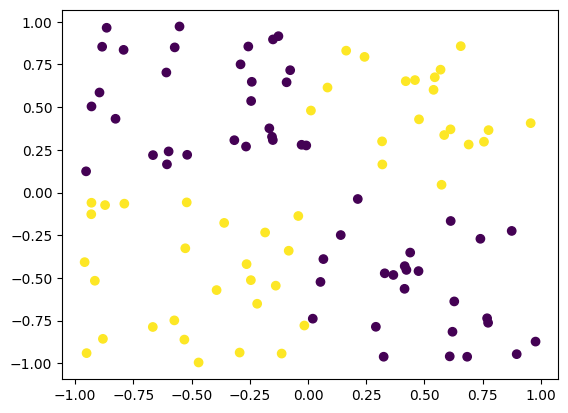

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y[:,0])

In [ ]:
model = nn.Sequential(nn.Linear(2, 5), nn.ReLU(), nn.Linear(5, 2))
print(model)
print(model(X).shape)
model(X)[:10]

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=2, bias=True)
)
torch.Size([100, 2])


tensor([[0.2255, 0.2631],
        [0.3354, 0.2420],
        [0.3157, 0.1004],
        [0.3769, 0.0882],
        [0.3463, 0.1916],
        [0.3308, 0.0974],
        [0.3062, 0.1710],
        [0.3322, 0.0971],
        [0.4162, 0.0485],
        [0.3689, 0.2053]], grad_fn=<SliceBackward0>)

In [ ]:
def visualize_fn(data, model, epoch, losses):
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from IPython.display import clear_output

    losses = list(map(lambda l: l.item() if isinstance(l, torch.Tensor) else l, losses))

    X, y = data
    xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-2.5, 2.5, 100))

    grid_tensor = torch.FloatTensor(np.stack([xx.ravel(), yy.ravel()], axis=1))
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = Z[:,0] - Z[:,1]

    Z = Z.reshape(xx.shape)

    fig = plt.figure(1, figsize=(10, 4))
    plt.subplot(1,2,1)
    CS = plt.contourf(xx, yy, Z, alpha=0.8)
    fig.colorbar(CS)
    plt.scatter(X[:, 0], X[:, 1], c=y[:,0])
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    plt.title(f"Classification with an MLP (epoch = {epoch})")

    fmt = '-' if len(losses) > 100 else '-o'
    plt.subplot(1,2,2)
    plt.plot(losses, fmt)
    plt.yscale('log')
    plt.grid(alpha=0.5)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. number of epochs")
    plt.tight_layout()
    clear_output(wait=True)
    plt.show()


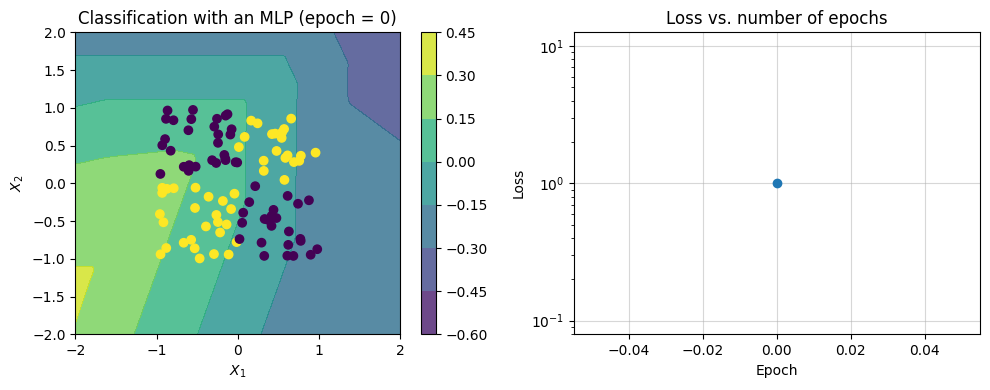

In [ ]:
visualize_fn(data, model, epoch=0, losses=[1])

In [ ]:
def train(data, model, epochs, visualize=True):
    X, y = data
    y = y.float()
    X = X.float()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        model.zero_grad()
        outputs = model(X)

        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 40 == 0 and visualize:
            visualize_fn(data, model, epoch + 1, losses)

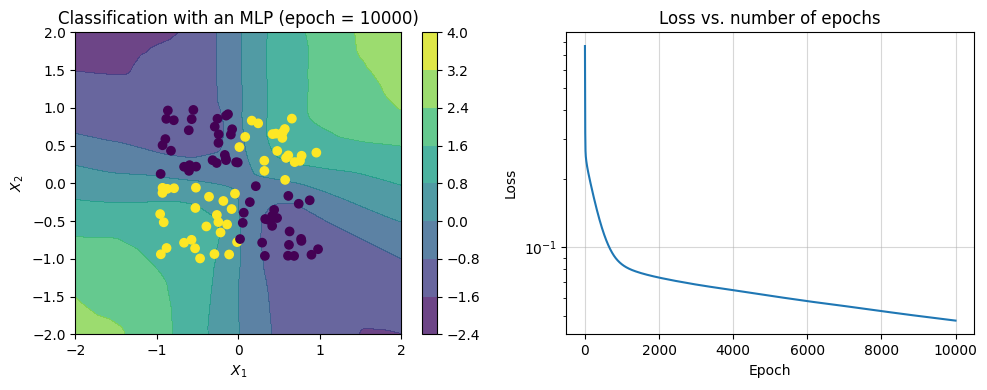

In [ ]:
model = nn.Sequential(nn.Linear(2, 100), nn.ReLU(), nn.Linear(100, 2))
train(data, model, 10000)

In [ ]:
def accuracy(data, model):
    X, y = data
    output = model(X)
    a = (output[:,1] - output[:,0]) * (y[:,1] - y[:,0]) > 0
    return torch.mean(a.float()).item()

In [ ]:
accuracy((X,y), model)